# Forecasting Future PTAs 
## for Periodic Light Curves


This notebook goes through the calculations needed to forecast the sensitivity of future pulsar timing arrays. Resources and detailed tutorials for using `hasasia` can be found on its [documentation page](https://hasasia.readthedocs.io). The various empirical distributions used for the sky positions, residual RMS values, cadences and timespans are based on either the distributions from known millisecond pulsars in [NANOGrav](https://arxiv.org/abs/1801.01837) and the [International Pulsar Timing Array, Perera, et al., 2019](https://arxiv.org/abs/1909.04534) or forecasted search numbers for the Square Kilometer Array from [Keane, et al., 2014](https://arxiv.org/abs/1501.00056).

Here we will plot sky-averaged PTA sensitivities against the h1$\sigma$ values for the top three values of strain from Table 1 in Xin, Mingarelli and Hazboun. The other notebook in this repository goes through making the specific sky maps and sky position-dependent  calculations for signal-to-noise ratio.

|Name|RA |DEC |Freq(Hz) |Strain|
|:---:|:---:|:---:|:-------:|:----:|
|3C66B|02 23 11.5|+42 59 30|6.02E-08|1.40E-14
|HS_1630+2355 |16 33 02.7 |+23 49 28.8 | 1.13E-08 | 6.25E-16|
|SDSS_J164452.71+430752.2 | 16 44 52.7 | +43 07 52.9 | 1.16E-08 | 4.94E-16|

In [1]:
import pickle, copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as utils
import hasasia.skymap as hsky

In [3]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

### Various convenience functions

__Note:__ The factor of two in these first two function is because of a difference in definition of the gravitational wave strain in `hasasia` and _Xin+2020_. 

In [4]:
def sky_ave_detect(sm,snr=3):
    snr /= 2
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/sm.Tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work

In [5]:
def sky_detect(sm,snr=3):
    snr /= 2
    return snr*np.sqrt(sm.S_eff/sm.tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work

In [6]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]

In [7]:
fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
freqs = np.sort(np.append(freqs,[1.13e-8])) #Append the frequency of candidate HS1630

### NANOGrav Sensitivity

Here we load in a full sky sensitivity map made using the NANOGrav 11-year data set. This curve uses noise parameters from the individual pulsars to build the covariance matrices, and is identical to the one used in [Arzoumanian, et al., 2020](https://arxiv.org/abs/2005.07123) to calculate the signal-to-noise ratio of 3C66B. Details for constructing skymaps from real pulsar timing data can be found [here](https://hasasia.readthedocs.io/en/latest/real_data_tutorial.html).

In [8]:
with open('ng11yr_sky_sensitivity_wn.has','rb') as fin:
    SM_ng11 = pickle.load(fin)

In [9]:
SkySNR_ng11 = SM_ng11.SNR(3.95e-16)

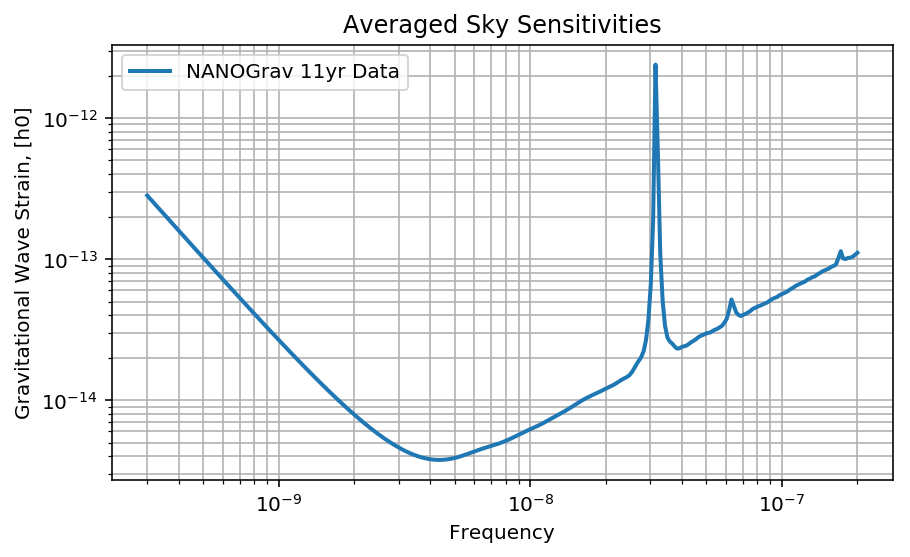

In [10]:
plt.figure(figsize=[7,4])
plt.loglog(SM_ng11.freqs,sky_ave_detect(SM_ng11,3),
           label='NANOGrav 11yr Data',lw=2)
plt.legend(loc='upper left')
plt.xlabel('Frequency')
plt.ylabel('Gravitational Wave Strain, [h0]')
plt.title('Averaged Sky Sensitivities')
plt.grid(which='both')
plt.show()

Here we load in a txt file with various attributes of the NANOGrav 11-year data set. We will use the cadences from here to help build the IPTA sensitivity curves.

In [11]:
ng11yr_psrs=np.loadtxt('ng11yr_psrs.txt',
                       dtype=[('psr', 'U32'), ('telescope', 'U32'),('full',float),
                              ('wn',float),('A_rn',float),('gamma',float),
                              ('theta',float),('phi',float),('cadence',float),('tspan',float)],
                       delimiter=',',
                       skiprows=1)

## IPTA 2025
Here we start with IPTA DR2 [(Perera, et al. 2019)](https://arxiv.org/abs/1909.04534) and add 4 pulsars per year with  RMS residual values pulled from a Gaussian distribution centered at 300 nanoseconds with a 100 ns standard deviation. The sky positions are pulled from a 2d distribution made from the current sky positions. 
* Residual RMS: `Normal(300ns,100ns)`
* Add 4 pulsars per year starting in 2015
* Sky position uses a `scipy.stats` rvs using current sky positions.   

In [12]:
ipta_dr2_noise=np.genfromtxt('./ipta_dr2_rms.txt', delimiter='\t', skip_header=1,
                                   dtype='U20, f4, f4, f4, f4',
                                   names=['psr','theta', 'phi','wn','tspan'])

In [13]:
cad_hist = np.histogram(2*ng11yr_psrs['cadence'], bins=20, density=True)
cad_rv = sps.rv_histogram(cad_hist)
cad_ipta = cad_rv.rvs(size=63)

In [14]:
tspans_ipta = ipta_dr2_noise['tspan']
cad_ipta = cad_ipta
phi_ipta = ipta_dr2_noise['phi']
theta_ipta = ipta_dr2_noise['theta']
sigmas_ipta = ipta_dr2_noise['wn']*1e-6

In [15]:
psrs_sim_dr2 = hsim.sim_pta(timespan=tspans_ipta,cad=cad_ipta,
                             sigma=sigmas_ipta,#A_rn=A,alpha=alphas,,freqs=freqs
                             phi=phi_ipta,theta=theta_ipta,uneven=True)

In [16]:
# Uncomment to save a pickled version of these pulsars.
# with open('my_ipta_dr2_has_psrs.pkl','wb') as fout:
#     pickle.dump(psrs_sim_dr2,fout)

In [17]:
specs_dr2 = []
for p in tspan_filter(psrs_sim_dr2):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_dr2.append(sp)

In [18]:
SM_dr2 = hsky.SkySensitivity(specs_dr2, theta_gw, phi_gw)

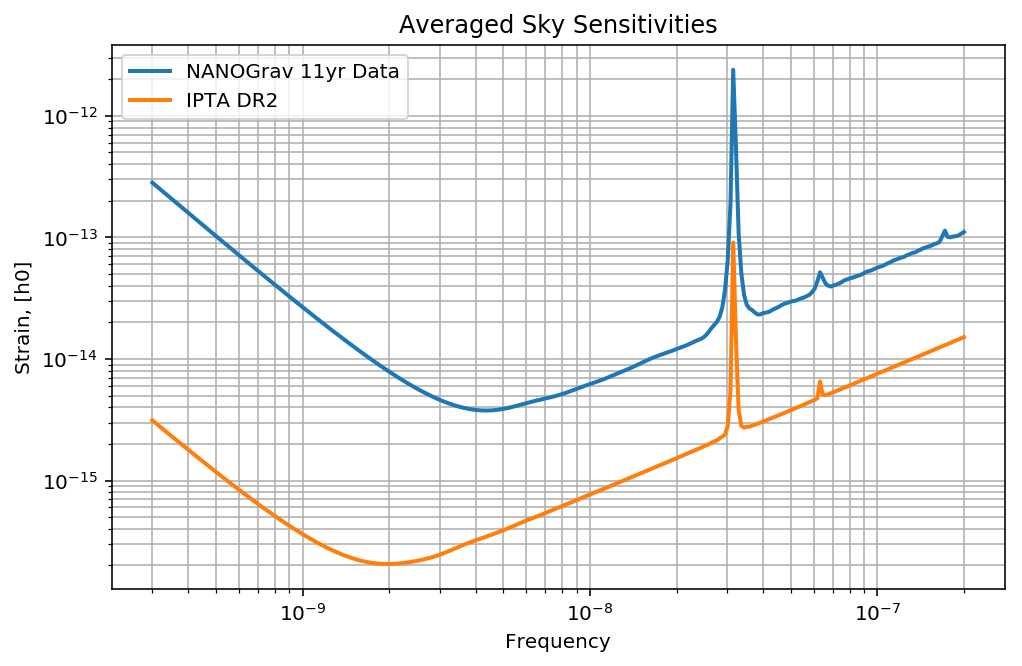

In [19]:
#Compare the sensitivity curves visually
plt.figure(figsize=[8,5])
plt.loglog(SM_ng11.freqs,sky_ave_detect(SM_ng11,3),
           label='NANOGrav 11yr Data',lw=2)
plt.loglog(SM_dr2.freqs,sky_ave_detect(SM_dr2,3),
           label='IPTA DR2',lw=2)
plt.legend(loc='upper left')
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Averaged Sky Sensitivities')
plt.grid(which='both')
plt.show()

## Making IPTA2025
Now that we have the current status of the IPTA pulsars from DR2 we project this PTA forward by pulling from empirical distributions made from the current set of pulsars. 

In [20]:
#Sky Location distributions
phi_hist = np.histogram(phi_ipta, bins=10, density=True)
phi_rv = sps.rv_histogram(phi_hist)
theta_hist = np.histogram(theta_ipta, bins=10, density=True)
theta_rv = sps.rv_histogram(theta_hist)

In [21]:
#Pull 40 new pulsars ( 4 per year for 10 years...)
theta_ipta_new = theta_rv.rvs(size=40)
phi_ipta_new = phi_rv.rvs(size=40)

Once we have empirical distributions we can pull 40 pulsars (4 per year for 10 years) and then plot to see the new sky locations.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


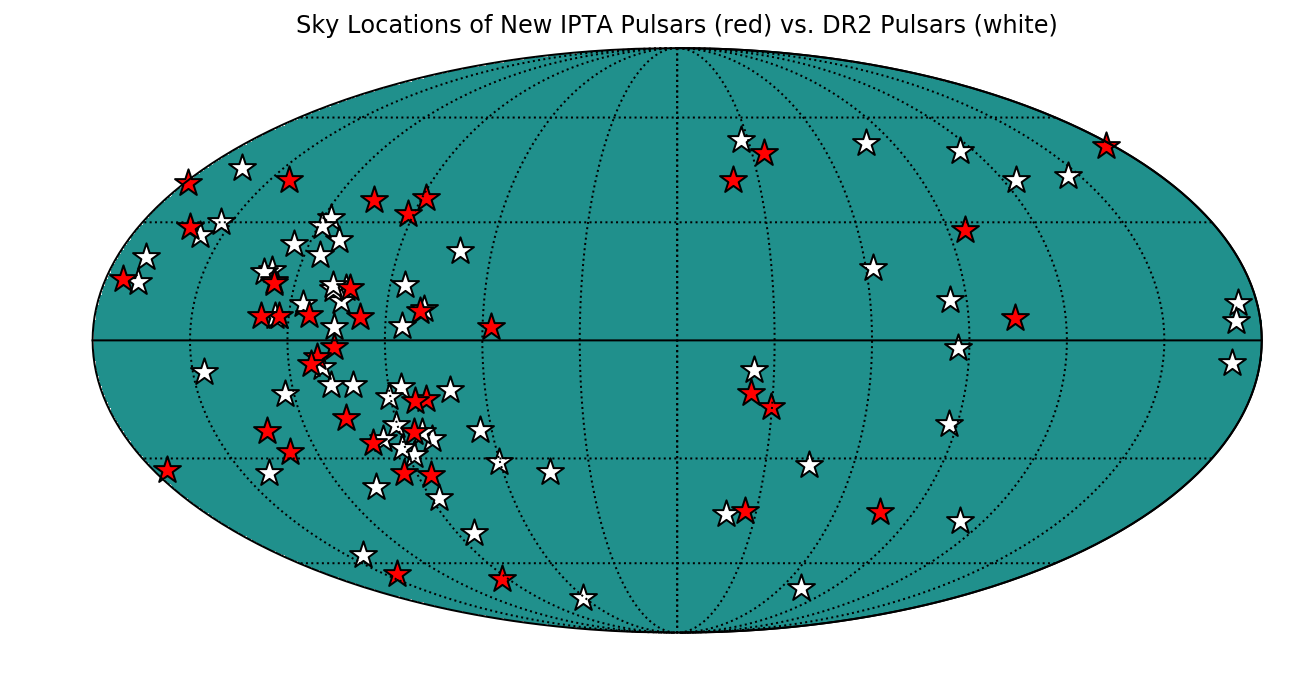

In [22]:
#Let's compare the new sky locations (red) to the current locations (white)

hp.mollview(np.ones_like(SM_dr2.S_effSky[0,:]),rot=(180,0,0),
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(theta_ipta,phi_ipta,marker='*',
                        color='white',edgecolors='k',s=200)
hp.visufunc.projscatter(theta_ipta_new,phi_ipta_new,
                        marker='*',
                        color='red',edgecolors='k',s=200)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.title('Sky Locations of New IPTA Pulsars (red) vs. DR2 Pulsars (white)')
plt.show()
plt.close()

### Building out IPTA 2025
After choosing the new sky positions we add more pulsars to the array at a rate of 4 per year for the 10 years following IPTA DR2.

In [23]:
#Add 4 pulsars per year
new_tspans = np.repeat(np.arange(1,11),4)
tspans_ipta_plus = np.append(ipta_dr2_noise['tspan']+10,new_tspans[::-1])

#Keep the average cadence of the DR2 pulsars
cad_ipta_plus = np.append(cad_ipta,23*np.ones_like(phi_ipta_new))

# Add to DR2 sky locations from scipy histograms above
phi_ipta_plus = np.append(ipta_dr2_noise['phi'],phi_ipta_new)
theta_ipta_plus = np.append(ipta_dr2_noise['theta'],theta_ipta_new)

#Use a truncated Gaussian distribution to pull residual RMS values.
lower, upper = 10e-9, 600e-9
mu, sigma = 300e-9, 100e-9 #Mean = 300ns, StDev = 100ns
rms_ipta_plus = sps.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
new_rms = rms_ipta_plus.rvs(40)
sigmas_ipta_plus = np.append(ipta_dr2_noise['wn']*1e-6, new_rms)
len(tspans_ipta_plus),len(phi_ipta_plus),len(theta_ipta_plus),len(sigmas_ipta_plus)

(103, 103, 103, 103)

Next we assume high cadence campaigns across the IPTA observations for pulsars with < 300ns precision.

In [24]:
for ii,rms in enumerate(sigmas_ipta_plus):
    if rms <300e-9:
        cad_ipta_plus[ii]=56

Once new pulsar parameters are made they are appended to the DR2 PTA parameters and we then make the new pulsar objects. 

In [25]:
#Make the pulsars using the noise parameters and sky locations from above
psrs_ipta_plus = hsim.sim_pta(timespan=tspans_ipta_plus,
                              cad=cad_ipta_plus,
                              sigma=sigmas_ipta_plus,
                              #A_rn=A,alpha=alphas,freqs=freqs, #One could add in red noise if desired
                              phi=phi_ipta_plus,
                              theta=theta_ipta_plus,uneven=True)

Each realization from the empirical distributions is slightly different, leading to slightly different projections for various sources. We have included the realizations used in the paper for the purposes of the analysis in the other notebook. However, if you would like to use your version then you can save a pickled list of pulsars at this point for further analysis by uncommented the lines in the next cell.

In [26]:
# with open('my_ipta_plus_has_psrs.pkl','wb') as fout:
#     pickle.dump(psrs_ipta_plus,fout)

## Make the individual spectra
The next steps calculate the noise weighted transmission function (NcalInv) for the individual pulsars and then calculated the full sky map from those quantities. See Hazboun+2018 for more details. 

In [27]:
specs_ipta_plus = []
for p in tspan_filter(psrs_ipta_plus):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_ipta_plus.append(sp)

In [28]:
SM_ipta_plus = hsky.SkySensitivity(specs_ipta_plus,theta_gw, phi_gw)

One can average the sensitivity across all sky locations in order to get a curve for sources across the sky.

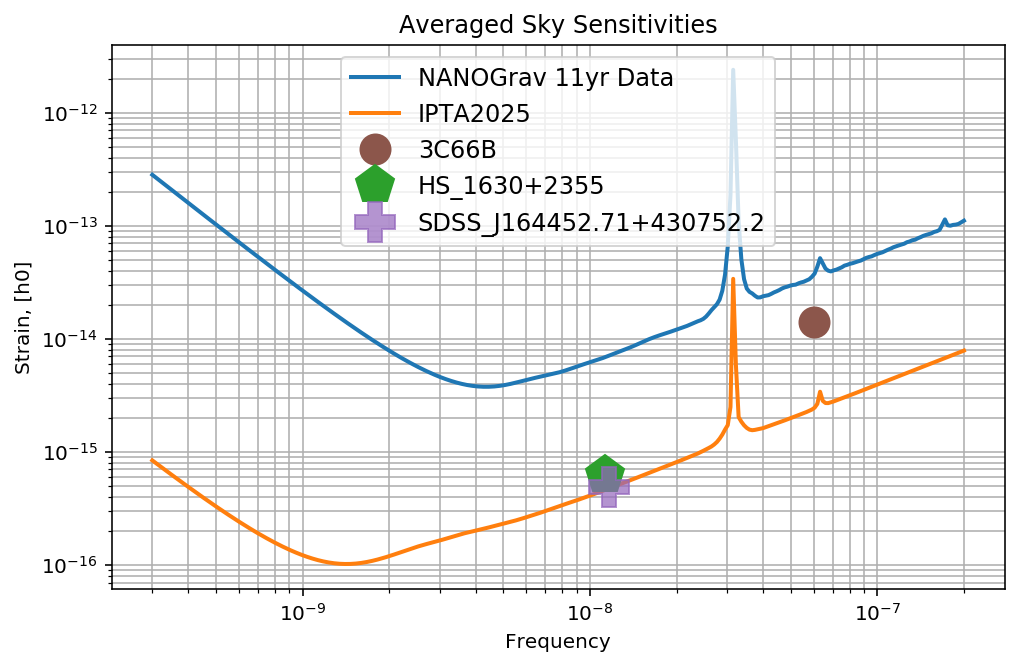

In [29]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ng11.freqs,sky_ave_detect(SM_ng11,snr),
           label='NANOGrav 11yr Data',lw=2)
plt.loglog(SM_ipta_plus.freqs,sky_ave_detect(SM_ipta_plus,snr),
           label='IPTA2025',lw=2)
plt.plot(6.02E-08, 1.40E-14,'.',markersize=30,color='C5',label='3C66B')
plt.plot(1.13e-08, 6.25E-16,'p',markersize=20,color='C2',label='HS_1630+2355')
plt.plot(1.16e-08, 4.94E-16,'P',markersize=20,linewidth=3,alpha=0.7,color='C4',label='SDSS_J164452.71+430752.2')
plt.legend(loc='upper center',fontsize=12)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Averaged Sky Sensitivities')
plt.grid(which='both')
plt.show()

## Making SKA1 PTA
Starting with the IPTA2025 from above and using [Keane, et al., 2014](https://arxiv.org/abs/1501.00056) we make a PTA based on the pulsars that will be found with SKA and the long baselines of data from the IPTA.

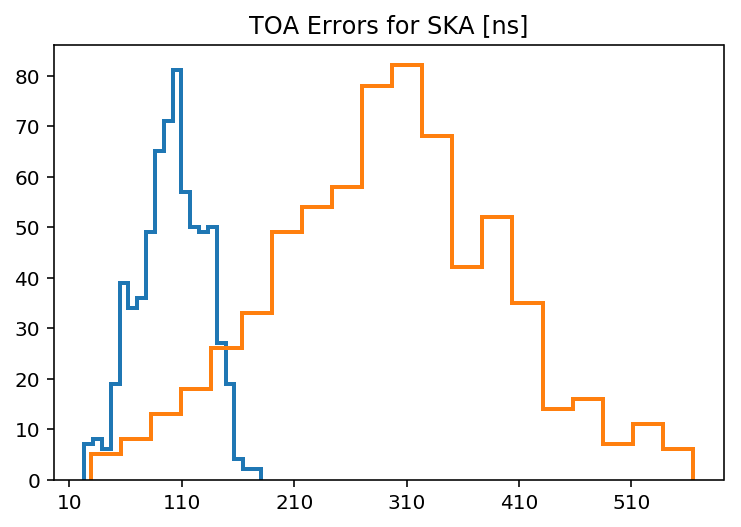

In [31]:
# Set the fraction of pulsars usable for PTA purposes and the number of pulsars found by SKA-LOW and SKA-MID
fraction = 0.15
Np_low = int(1500*fraction)
Np_mid = int(3000*fraction)

#Here we build two distributions from which to pull RMS values.

#Optimistic
lower1, upper1 = 9e-9, 201e-9
mu1, sigma1 = 100e-9, 30e-9
RVSopt = sps.truncnorm((lower1 - mu1) / sigma1, (upper1 - mu1) / sigma1, loc=mu1, scale=sigma1)

#Conservative (basically matches the IPTA2025 distribution)
lower2, upper2 = 9e-9, 601e-9
mu2, sigma2 = 300e-9, 100e-9
RVScons = sps.truncnorm((lower2 - mu2) / sigma2, (upper2 - mu2) / sigma2, loc=mu2, scale=sigma2)

errors_opt = RVSopt.rvs(Np_low+Np_mid)
errors_cons = RVScons.rvs(Np_low+Np_mid)

plt.hist(errors_opt/1e-9,bins=20,histtype='step',label='Optimistic',lw=2)
plt.hist(errors_cons/1e-9,bins=20,histtype='step',label='Pessimistic',lw=2)
plt.xticks(np.arange(10,610,100))
plt.title('TOA Errors for SKA [ns]')
plt.show()
plt.close()

l_low = np.random.uniform(0,2*np.pi,size=Np_low)
sinb_low_a = np.random.uniform(np.sin(np.deg2rad(-90)),np.sin(np.deg2rad(-5)),size=Np_low//2)
sinb_low_b = np.random.uniform(np.sin(np.deg2rad(5)),np.sin(np.deg2rad(90)),size=Np_low//2 + Np_low%2)
sinb_low = np.append(sinb_low_a, sinb_low_b)
b_low = np.arcsin(sinb_low)
sky_pos_low = SkyCoord(l=l_low*u.rad, b=b_low*u.rad, frame='galactic')
phis_low = sky_pos_low.icrs.ra.to('rad').value
thetas_low = np.pi/2-sky_pos_low.icrs.dec.to('rad').value

l_mid = np.random.uniform(0,2*np.pi,size=Np_mid)
sinb_mid = np.random.uniform(np.sin(np.deg2rad(-10)),np.sin(np.deg2rad(10)),size=Np_mid)
b_mid = np.arcsin(sinb_mid)
sky_pos_mid = SkyCoord(l=l_mid*u.rad, b=b_mid*u.rad, frame='galactic')
phis_mid = sky_pos_mid.icrs.ra.to('rad').value
thetas_mid = np.pi/2-sky_pos_mid.icrs.dec.to('rad').value
new_phis_ska1 = np.append(phis_low,phis_mid)
new_thetas_ska1 = np.append(thetas_low,thetas_mid)


### SKA Pulsar sky positions


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


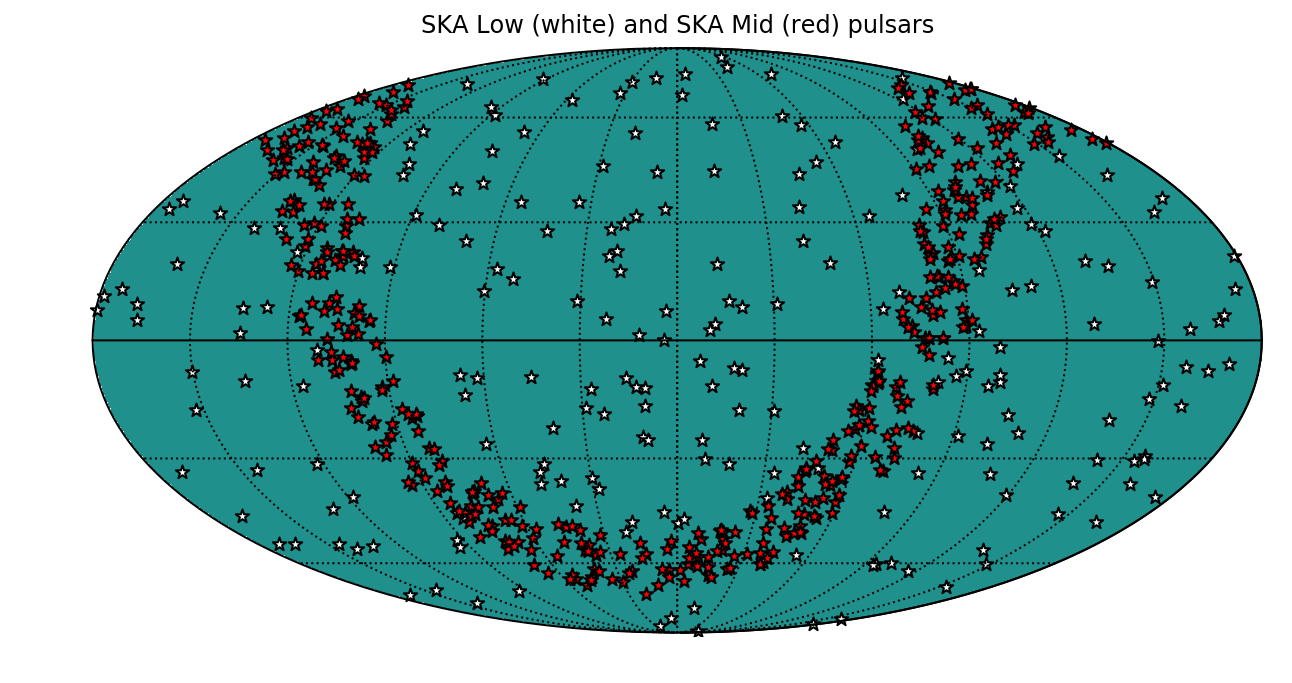

In [32]:
hp.mollview(np.ones(NPIX),rot=(180,0,0),
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(thetas_low,phis_low,marker='*',
                        color='white',edgecolors='k',s=50)
hp.visufunc.projscatter(thetas_mid,phis_mid,marker='*',
                        color='red',edgecolors='k',s=50)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.title('SKA Low (white) and SKA Mid (red) pulsars')
plt.show()
plt.close()

In [33]:
#Add 4 pulsars per year
tspans_ska1 = np.append(tspans_ipta_plus+5, np.random.uniform(low=1,high=4,size=Np_low+Np_mid))

#Keep the average cadence of the IPTA DR2 pulsars and add weekly observations of new pulsars 
cad_ska1 = np.append(cad_ipta_plus,56*np.ones(Np_low+Np_mid))

# Add to DR2 sky locations from scipy histograms above
phis_ska1 = np.append(phi_ipta_plus,new_phis_ska1)
thetas_ska1 = np.append(theta_ipta_plus,new_thetas_ska1)


sigma_ska1o = np.append(sigmas_ipta_plus,errors_opt)
sigma_ska1c = np.append(sigmas_ipta_plus,errors_cons)

#Here we simulate the pulsars. The commented out pieces will ad a GWB with the NG11yr UL
ska1_opt = hsim.sim_pta(timespan=tspans_ska1,cad=cad_ska1,
                        sigma=sigma_ska1o,phi=phis_ska1,theta=thetas_ska1)#,A_rn=1.42e-15,alpha=-2/3.,freqs=freqs)
ska1_cons = hsim.sim_pta(timespan=tspans_ska1,cad=cad_ska1,
                         sigma=sigma_ska1c,phi=phis_ska1,theta=thetas_ska1)#,A_rn=1.42e-15,alpha=-2/3.,freqs=freqs)

In [34]:
# with open('my_ska1_cons_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska1_cons,fout)
# with open('my_ska1_opt_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska1_opt,fout)
# with open('my_ska1_opt_has_psrs_wGWB_ng11yr.pkl','wb') as fout:
#     pickle.dump(ska1_opt,fout)

In [35]:
len(ska1_opt)

778

In [36]:
spec_ska1_opt = []
for p in tspan_filter(ska1_opt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska1_opt.append(sp)

In [37]:
spec_ska1_cons = []
for p in tspan_filter(ska1_cons):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska1_cons.append(sp)

In [38]:
SM_ska1_opt = hsky.SkySensitivity(spec_ska1_opt, theta_gw, phi_gw)
SM_ska1_cons = hsky.SkySensitivity(spec_ska1_cons,theta_gw, phi_gw)

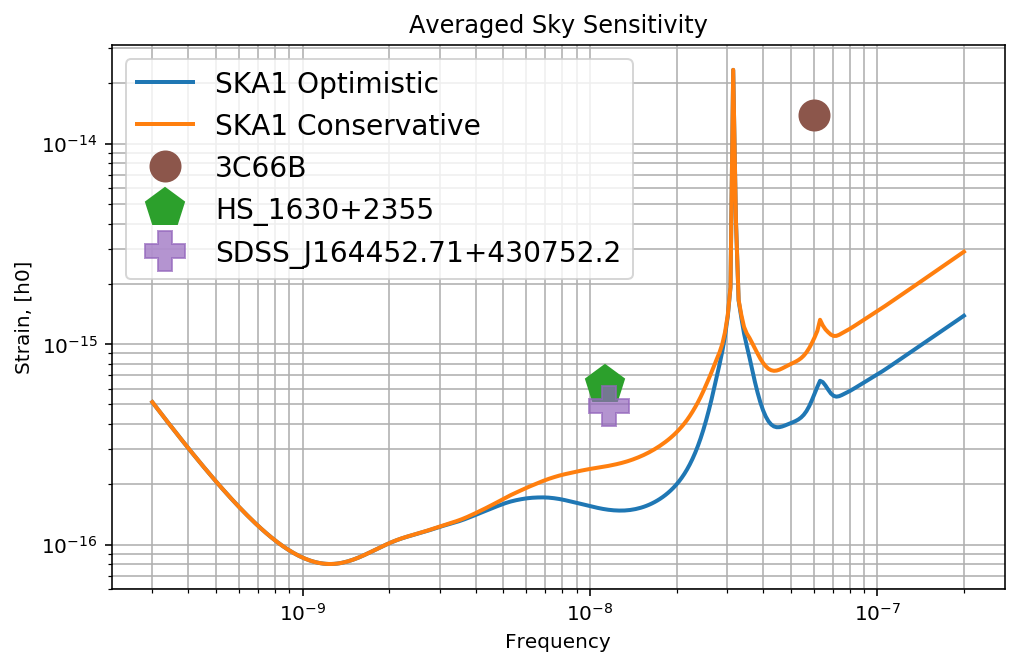

In [39]:
snr=3
plt.figure(figsize=[8,5])

plt.loglog(SM_ska1_opt.freqs,sky_ave_detect(SM_ska1_opt,snr),
           label='SKA1 Optimistic',lw=2)
plt.loglog(SM_ska1_cons.freqs,sky_ave_detect(SM_ska1_cons,snr),
           label='SKA1 Conservative',lw=2)
plt.plot(6.02E-08, 1.40E-14,'.',markersize=30,color='C5',label='3C66B')
plt.plot(1.13e-08, 6.25E-16,'p',markersize=20,color='C2',label='HS_1630+2355')
plt.plot(1.16e-08, 4.94E-16,'P',markersize=20,linewidth=3,alpha=0.7,color='C4',label='SDSS_J164452.71+430752.2')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Averaged Sky Sensitivity')
plt.grid(which='both')
plt.show()

## SKA2
In the second phase of SKA another set of pulsars is predicted to be found. Here we assume more uniform distribution of these across the sky. 

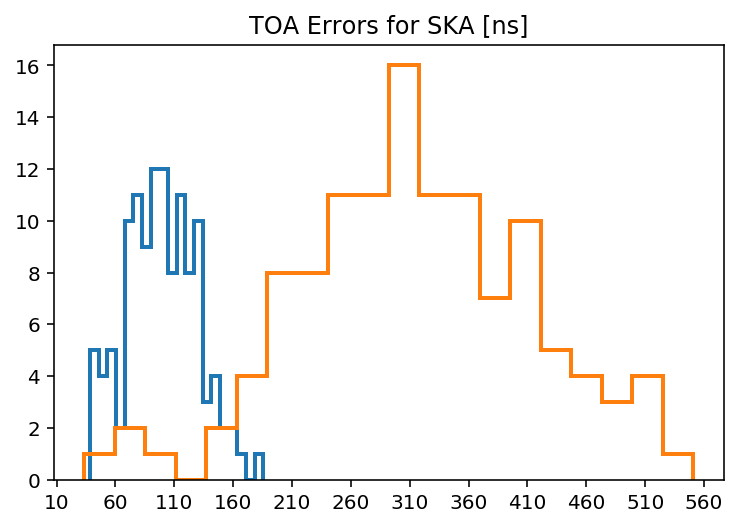

In [40]:
Np_ska2 = int(800*fraction)

ska2_errors_opt = RVSopt.rvs(Np_ska2)
ska2_errors_cons = RVScons.rvs(Np_ska2)

plt.hist(ska2_errors_opt/1e-9,bins=20,histtype='step',label='Optimistic',lw=2)
plt.hist(ska2_errors_cons/1e-9,bins=20,histtype='step',label='Pessimistic',lw=2)
plt.xticks(np.arange(10,610,50))
plt.title('TOA Errors for SKA [ns]')
plt.show()
plt.close()

new_phis_ska2 = np.random.uniform(0, 2*np.pi, size=Np_ska2)
cosTheta_ska2 = np.random.uniform(-1,1,size=Np_ska2)
new_thetas_ska2 = np.arccos(cosTheta_ska2)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


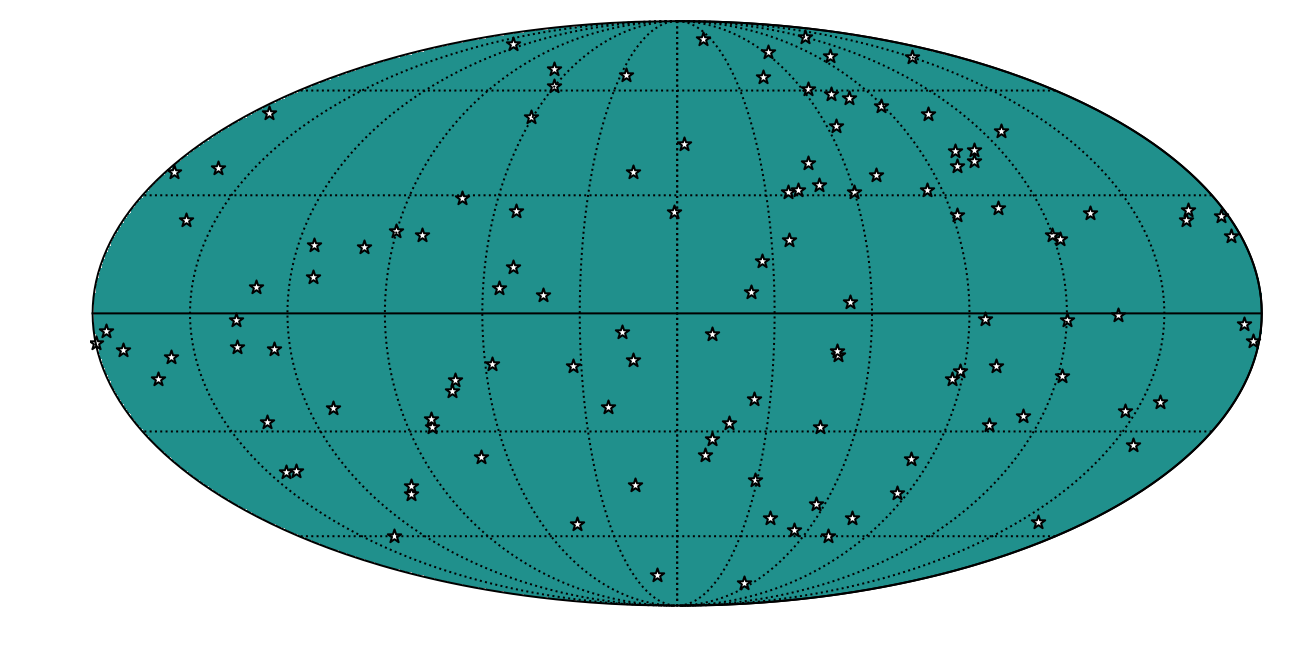

In [41]:
hp.mollview(np.ones_like(SM_ipta_plus.S_effSky[0,:]),rot=(180,0,0),
            cmap='viridis',cbar=None,title='')
hp.visufunc.projscatter(new_thetas_ska2,new_phis_ska2,marker='*',
                        color='white',edgecolors='k',s=50)
hp.graticule()
fig = plt.gcf()
ax = plt.gca()
plt.show()
plt.close()

In [42]:
#Add 4 pulsars per year
tspans_ska2 = np.append(tspans_ska1+4,np.random.uniform(low=1,high=4,size=Np_ska2))
#Keep the average cadence of the NG11yr pulsars
cad_ska2 = np.append(cad_ska1,56*np.ones(Np_ska2))
# Add to DR2 sky locations from scipy histograms above
phis_ska2 = np.append(phis_ska1,new_phis_ska2)
thetas_ska2 = np.append(thetas_ska1,new_thetas_ska2)


sigma_ska2o = np.append(sigma_ska1o,ska2_errors_opt)
sigma_ska2c = np.append(sigma_ska1c,ska2_errors_cons)

ska2_opt = hsim.sim_pta(timespan=tspans_ska2,cad=cad_ska2,
                        sigma=sigma_ska2o,phi=phis_ska2,theta=thetas_ska2,A_rn=1e-15,alpha=-2/3.,freqs=freqs)
ska2_cons = hsim.sim_pta(timespan=tspans_ska2,cad=cad_ska2,
                         sigma=sigma_ska2c,phi=phis_ska2,theta=thetas_ska2,A_rn=1e-15,alpha=-2/3.,freqs=freqs)

In [43]:
# with open('ska2_cons_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska2_cons,fout)
# with open('ska2_opt_has_psrs.pkl','wb') as fout:
#     pickle.dump(ska2_opt,fout)

If one wants to add a GWB to these simulations that can be done by adding it into the correlation matrix directly.

In [ ]:
# gwb = hsen.red_noise_powerlaw(A=1.92e-15,alpha=-2/3.,freqs=freqs)
# for pc,po in zip(ska2_cons,ska2_opt):
#     pc.N += hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=pc.toas)
#     po.N += hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=po.toas)

In [44]:
spec_ska2_opt = []
for p in tspan_filter(ska2_opt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska2_opt.append(sp)

In [45]:
spec_ska2_cons = []
for p in tspan_filter(ska2_cons):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska2_cons.append(sp)

In [46]:
SM_ska2_opt = hsky.SkySensitivity(spec_ska2_opt, theta_gw, phi_gw)
SM_ska2_cons = hsky.SkySensitivity(spec_ska2_cons,theta_gw, phi_gw)

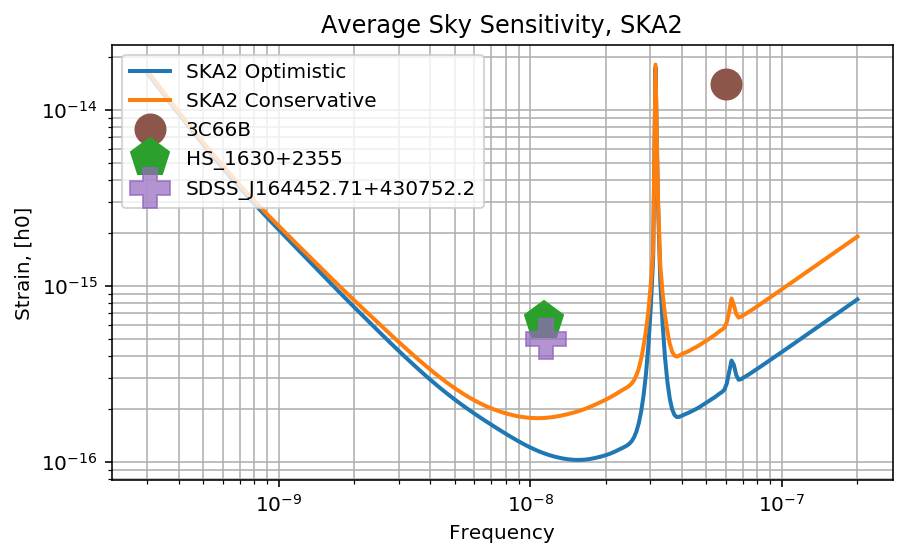

In [47]:
plt.figure(figsize=[7,4])
plt.loglog(SM_ska2_opt.freqs,sky_ave_detect(SM_ska2_opt,3),
           label='SKA2 Optimistic',lw=2)
plt.loglog(SM_ska2_cons.freqs,sky_ave_detect(SM_ska2_cons,3),
           label='SKA2 Conservative',lw=2)
plt.plot(6.02E-08, 1.40E-14,'.',markersize=30,color='C5',label='3C66B')
plt.plot(1.13e-08, 6.25E-16,'p',markersize=20,color='C2',label='HS_1630+2355')
plt.plot(1.16e-08, 4.94E-16,'P',markersize=20,linewidth=3,alpha=0.7,color='C4',label='SDSS_J164452.71+430752.2')

plt.legend(loc='upper left')
plt.xlabel('Frequency')
plt.ylabel('Strain, [h0]')
plt.title('Average Sky Sensitivity, SKA2')
plt.grid(which='both')
plt.show()

## Old Pulsars, New Telescopes

When the SKA is fully operational many known pulsars can then be observed with much improved noise characteristics. Here we assume that only three of these pulsars will be observed with the SKA, and hence these are fairly conservative numbers. It is these versions of the SKA1/SKA2, with three currently timed pulsars added, that we use in our paper.

In [48]:
j1909_idx=list(ipta_dr2_noise['psr']).index('J1909-3744')
j1713_idx=list(ipta_dr2_noise['psr']).index('J1713+0747')
j1640_idx=list(ipta_dr2_noise['psr']).index('J1640+2224')

Use the jitter-limited values for the RMS values of these pulsars from [Lam, et al., 2019](https://iopscience.iop.org/article/10.3847/1538-4357/ab01cd).

In [49]:
j1909_jitter = 20e-9
j1713_jitter = 40e-9
j1640_jitter = 12e-9

In [50]:
ska1_opt_alt = copy.deepcopy(ska1_opt)

In [51]:
# This is needed for adding in a GWB
# gwb = hsen.red_noise_powerlaw(A=1.92e-15,alpha=-2/3.,freqs=freqs)

Here we replace the TOA errors in the SKA era with the jitter-limited values above. Uncomment last line to add GWB.

In [52]:
ska1_opt_alt[j1909_idx].toaerrs[ska1_opt_alt[j1909_idx].toas/(24*3600)>ska1_opt_alt[j1909_idx].toas[-1]/(24*3600)-(365.25*5)]=20e-9
ska1_opt_alt[j1909_idx].N = np.diag(ska1_opt_alt[j1909_idx].toaerrs**2) 
#                              + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska1_opt_alt[j1909_idx].toas)

In [53]:
ska1_opt_alt[j1713_idx].toaerrs[ska1_opt_alt[j1713_idx].toas/(24*3600)>ska1_opt_alt[j1713_idx].toas[-1]/(24*3600)-(365.25*5)]=40e-9
ska1_opt_alt[j1713_idx].N = np.diag(ska1_opt_alt[j1713_idx].toaerrs**2)
#                              + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska1_opt_alt[j1713_idx].toas)

In [54]:
ska1_opt_alt[j1640_idx].toaerrs[ska1_opt_alt[j1640_idx].toas/(24*3600)>ska1_opt_alt[j1640_idx].toas[-1]/(24*3600)-(365.25*5)]=12e-9
ska1_opt_alt[j1640_idx].N = np.diag(ska1_opt_alt[j1640_idx].toaerrs**2)
#                              + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska1_opt_alt[j1640_idx].toas)

In [ ]:
# with open('ska2_opt_jitter_has_psrswGWB_ng11yr.pkl','wb') as fout:
#     pickle.dump(ska2_opt_alt2,fout)

In [55]:
spec_ska1_opt_alt = []
for p in tspan_filter(ska1_opt_alt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska1_opt_alt.append(sp)

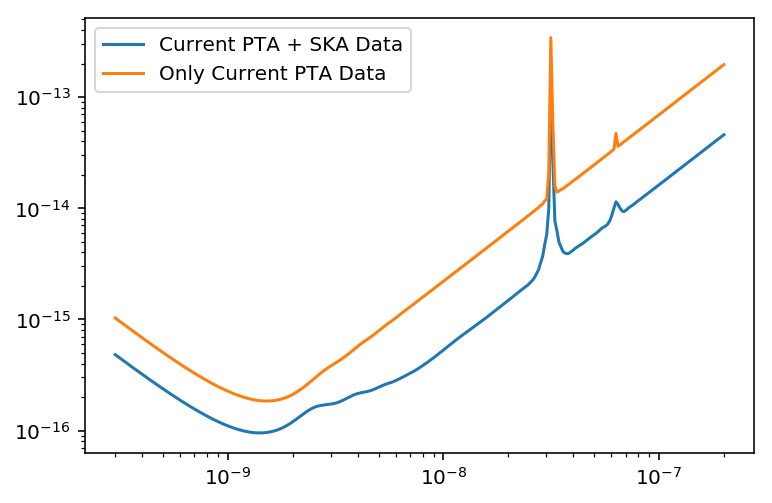

In [57]:
plt.loglog(freqs,spec_ska1_opt_alt[j1909_idx].h_c,label='Current PTA + SKA Data')
plt.loglog(freqs,spec_ska1_opt[j1909_idx].h_c, label='Only Current PTA Data')
plt.legend(loc='upper left')
plt.show()

In [58]:
ska2_opt_alt = copy.deepcopy(ska2_opt)

In [59]:
ska2_opt_alt[j1909_idx].toaerrs[ska2_opt_alt[j1909_idx].toas/(24*3600)>ska2_opt_alt[j1909_idx].toas[-1]/(24*3600)-(365.25*5)]=20e-9
ska2_opt_alt[j1909_idx].N = np.diag(ska2_opt_alt[j1909_idx].toaerrs**2)

In [60]:
ska2_opt_alt[j1713_idx].toaerrs[ska2_opt_alt[j1713_idx].toas/(24*3600)>ska2_opt_alt[j1713_idx].toas[-1]/(24*3600)-(365.25*5)]=40e-9
ska2_opt_alt[j1713_idx].N = np.diag(ska2_opt_alt[j1713_idx].toaerrs**2)

In [61]:
ska2_opt_alt[j1640_idx].toaerrs[ska2_opt_alt[j1640_idx].toas/(24*3600)>ska2_opt_alt[j1640_idx].toas[-1]/(24*3600)-(365.25*5)]=12e-9
ska2_opt_alt[j1640_idx].N = np.diag(ska2_opt_alt[j1640_idx].toaerrs**2)

In [62]:
# These versions add in a GWB
# ska2_opt_alt2 = copy.deepcopy(ska2_opt)
# ska2_opt_alt2[j1909_idx].toaerrs[ska2_opt_alt2[j1909_idx].toas/(24*3600)>ska2_opt_alt2[j1909_idx].toas[-1]/(24*3600)-(365.25*5)]=20e-9
# ska2_opt_alt2[j1909_idx].N = (np.diag(ska2_opt_alt2[j1909_idx].toaerrs**2)
#                               + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska2_opt_alt2[j1909_idx].toas))
# ska2_opt_alt2[j1713_idx].toaerrs[ska2_opt_alt2[j1713_idx].toas/(24*3600)>ska2_opt_alt2[j1713_idx].toas[-1]/(24*3600)-(365.25*5)]=40e-9
# ska2_opt_alt2[j1713_idx].N = (np.diag(ska2_opt_alt2[j1713_idx].toaerrs**2)
#                               + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska2_opt_alt2[j1713_idx].toas))
# ska2_opt_alt2[j1640_idx].toaerrs[ska2_opt_alt2[j1640_idx].toas/(24*3600)>ska2_opt_alt2[j1640_idx].toas[-1]/(24*3600)-(365.25*5)]=12e-9
# ska2_opt_alt2[j1640_idx].N = (np.diag(ska2_opt_alt2[j1640_idx].toaerrs**2)
#                               + hsen.corr_from_psd(freqs=freqs, psd=gwb, toas=ska2_opt_alt2[j1640_idx].toas))

In [63]:
spec_ska2_opt_alt = []
for p in tspan_filter(ska2_opt_alt):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    spec_ska2_opt_alt.append(sp)

In [64]:
SM_ska1_opt_alt = hsky.SkySensitivity(spec_ska1_opt_alt, theta_gw, phi_gw)

In [65]:
SM_ska2_opt_alt = hsky.SkySensitivity(spec_ska2_opt_alt, theta_gw, phi_gw)